# Building Energy Consumption Prediction for Seattle

This notebook guides through the process of exploring, cleaning, analyzing, and modeling data to predict energy needs and emissions for buildings in Seattle.

## Project Overview

The city of Seattle aims to become carbon-neutral by 2050. Our mission is to use data collected in 2016 to develop a predictive model that estimates:
- Total energy consumption
- CO2 emissions

These predictions will focus exclusively on non-residential buildings for which measurements have not yet been taken.

## Project Objectives

1. Perform exploratory analysis of building data
2. Develop a model to predict energy consumption
3. Develop a model to predict CO2 emissions
4. Evaluate the importance of ENERGY STAR Score as a predictor
5. Identify building characteristics that most influence energy consumption

## Methodological Approach

Our approach will follow several key steps:

1. **Data loading and initial exploration**
2. **Cleaning and preprocessing**
3. **In-depth exploratory analysis**
4. **Feature engineering and variable creation**
5. **Modeling with different algorithms**
6. **Hyperparameter optimization**
7. **Model evaluation**
8. **Feature importance analysis**
9. **Specific study of ENERGY STAR Score impact**
10. **Conclusions and recommendations**

## Step 1: Data Loading and Initial Exploration

Let's start by loading the dataset and exploring its structure.



In [1]:
import os
import pandas as pd
from src.utils.cache_load_df import load_or_cache_dataframes

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 5)
pd.set_option('display.width', 1000)

# Define the dataset directory
dataset_directory = os.path.join(os.getcwd(), 'dataset')
 
# Define cache directory for storing processed dataframes
CACHE_DIR = os.path.join(os.getcwd(), 'data', 'cache')
os.makedirs(CACHE_DIR, exist_ok=True)

# Load the Open Food Facts dataset
specific_files = ['2016_Building_Energy_Benchmarking.csv']
dfs = load_or_cache_dataframes(dataset_directory, CACHE_DIR, file_list=specific_files, separator=',')

df = dfs['2016_Building_Energy_Benchmarking']

# Filter to keep only compliant buildings without outliers
df = df[(df['ComplianceStatus'] == 'Compliant') & (df['Outlier'].isna())]

# Filter to keep only non-residential buildings
df = df[df['BuildingType'].isin(['NonResidential', 'Nonresidential COS', 'Nonresidential WA'])]

df.head()


Loading 2016_Building_Energy_Benchmarking.csv from cache...
Loaded 2016_Building_Energy_Benchmarking.csv from cache successfully in 0.00 seconds.

DataFrame: 2016_Building_Energy_Benchmarking
Shape: (3376, 46) (3376 rows, 46 columns)
Memory usage: 1.16 MB
Missing values: 19952 (12.85% of all cells)

Data Types:
  float64: 22 columns
  object: 15 columns
  int64: 8 columns
  bool: 1 columns

Column names preview:
OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber... and 36 more


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88




## Step 2: Create Metadata and Initial Analysis

Let's create functions to analyze the dataset's structure and create metadata.



=== Metadata Summary: 2016_Building_Energy_Benchmarking ===


,DataFrame,Column Name,Data Type,Non-Null Count,Null Count,Fill Rate (%),Unique Count,Unique Rate (%),Most Common Value,Most Common Count
0,2016_Building_Energy_Benchmarking,OSEBuildingID,int64,3376,0,100.0,3376,100.00,50101,1
1,2016_Building_Energy_Benchmarking,DataYear,int64,3376,0,100.0,1,0.03,2016,3376
...,...,...,...,...,...,...,...,...,...,...
40,2016_Building_Energy_Benchmarking,DefaultData,bool,3376,0,100.0,2,0.06,False,3263
42,2016_Building_Energy_Benchmarking,ComplianceStatus,object,3376,0,100.0,4,0.12,Compliant,3211


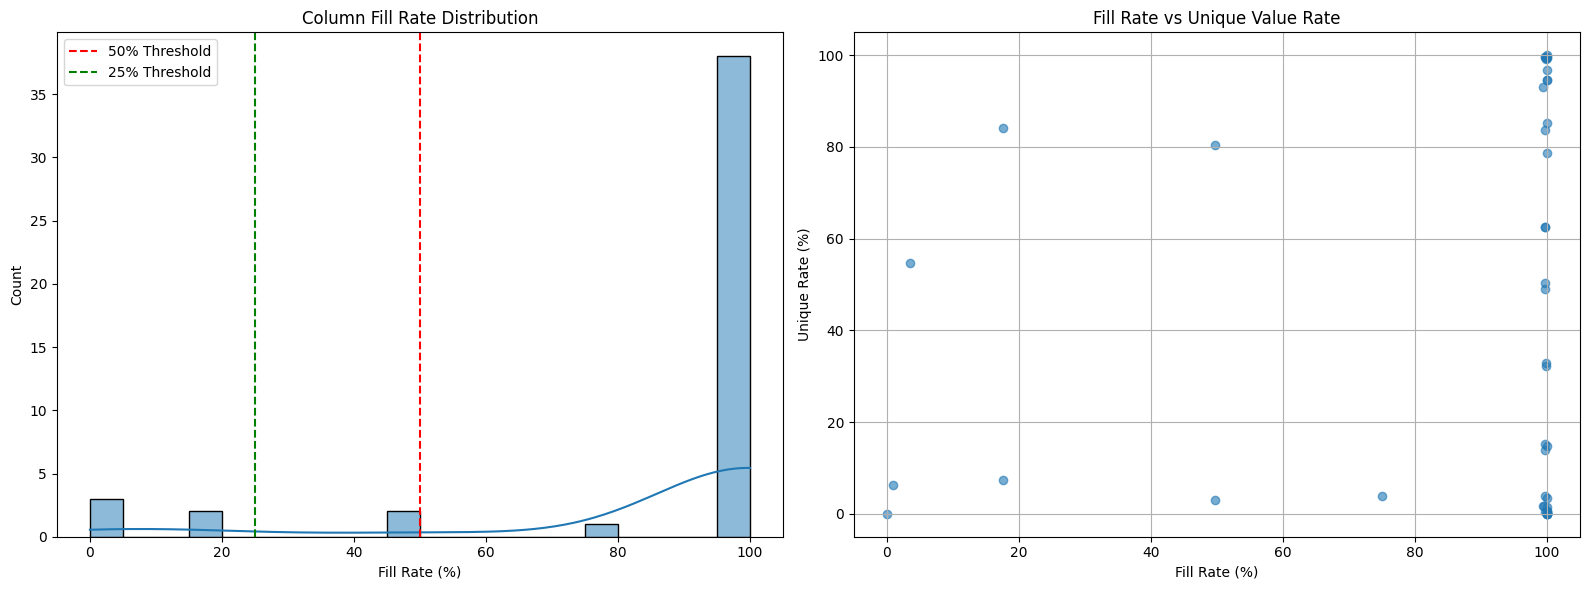


=== Column Categories ===
Total columns: 46
• High fill rate (≥25%): 41 columns
  - ID-like columns: 11 columns
    OSEBuildingID, PropertyName, Address, TaxParcelIdentificationNumber, PropertyGFATotal, PropertyGFABuilding(s), LargestPropertyUseTypeGFA, SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), Electricity(kWh), Electricity(kBtu)
  - Categorical columns: 1 columns
    ListOfAllPropertyUseTypes
  - Binary/flag columns: 3 columns
    City, DefaultData, ComplianceStatus
  - Numeric columns: 20 columns
    DataYear, ZipCode, CouncilDistrictCode, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFAParking, SecondLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SteamUse(kBtu), NaturalGas(therms), NaturalGas(kBtu), TotalGHGEmissions, GHGEmissionsIntensity
• Low fill rate (<25%): 5 columns


<Figure size 1600x800 with 0 Axes>

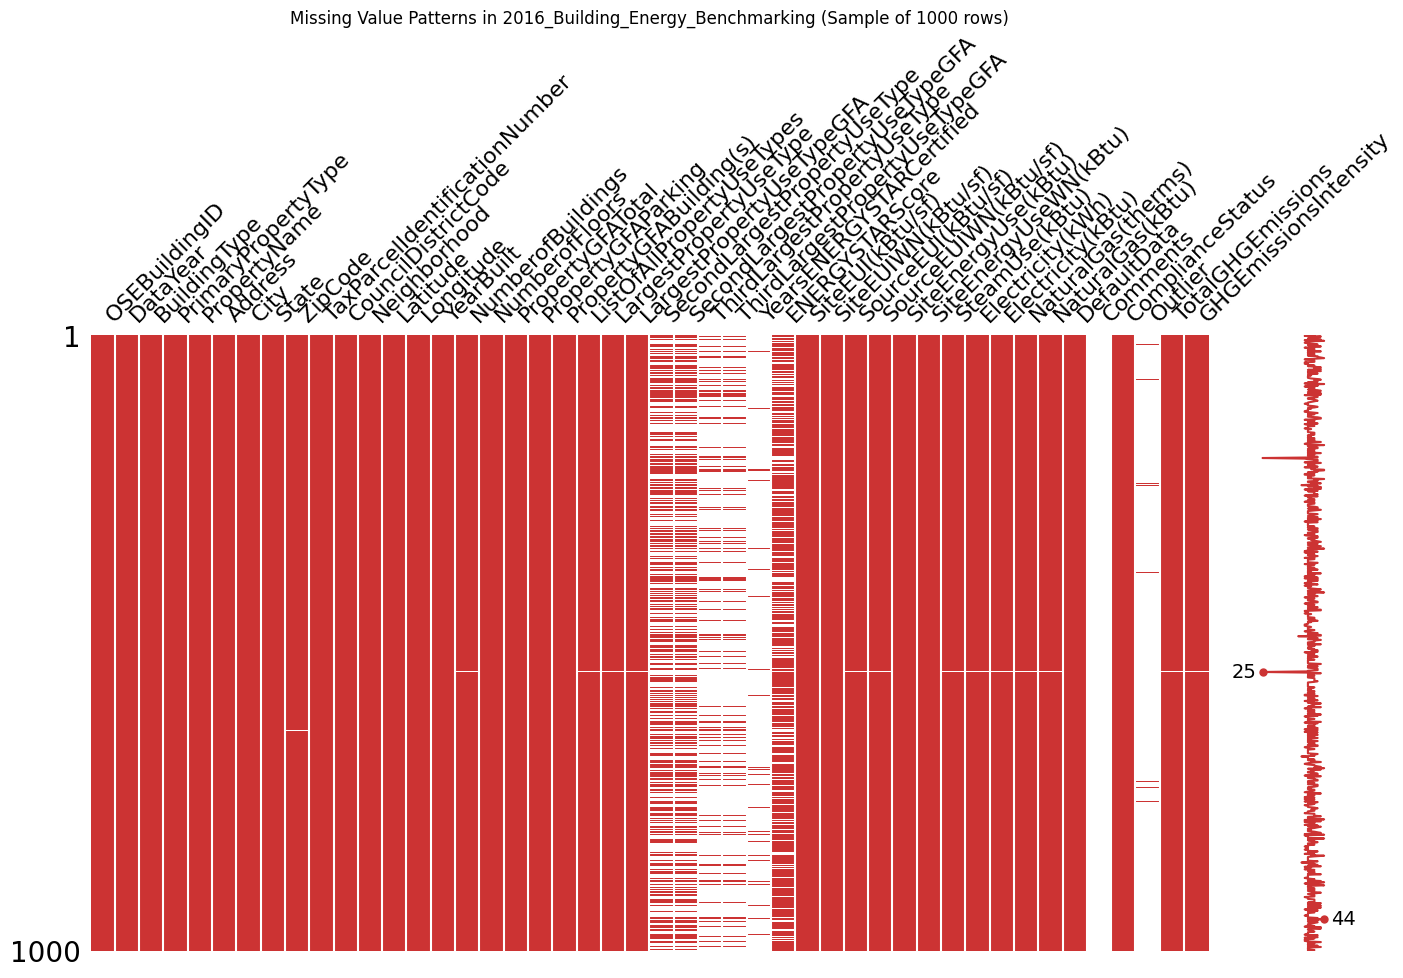

In [2]:
from src.scripts.analyze_df_structure import create_metadata_dfs, display_metadata_dfs
import matplotlib.pyplot as plt
import missingno as msno

# Generate metadata for the loaded dataframes
metadata_dfs = create_metadata_dfs(dfs)
display_metadata_dfs(metadata_dfs)

# Create a missing value visualization
for name, df in dfs.items():
    plt.figure(figsize=(16, 8))
    msno.matrix(df.sample(min(1000, len(df))), figsize=(16, 8), color=(0.8, 0.2, 0.2))
    plt.title(f"Missing Value Patterns in {name} (Sample of {min(1000, len(df))} rows)")
    plt.show()

## Step 3: Enhanced Metadata Cluster Visualization Analysis

### Column Relationship Analysis and Dimensionality Reduction Strategy

The interactive metadata clustering visualization reveals important patterns in our Seattle building energy dataset structure that can guide our feature selection and dimensionality reduction efforts:

### Key Observations

1. **Similar Fill Rate Patterns**: Multiple columns show nearly identical fill rates, suggesting related or redundant information:
   - Energy measurement fields in different units (e.g., `Electricity(kWh)` and `Electricity(kBtu)`)
   - Building size metrics (`PropertyGFATotal`, `PropertyGFABuilding(s)`, `PropertyGFAParking`)
   - Energy usage metrics with and without weather normalization (e.g., `SiteEUI(kBtu/sf)` and `SiteEUIWN(kBtu/sf)`)

2. **Content Duplication**: Several column groups contain essentially the same information in different formats:
   - Multiple identifiers for the same building (`OSEBuildingID`, `TaxParcelIdentificationNumber`)
   - Energy consumption in different units (kWh, kBtu, therms)
   - Area measurements for different building sections and usage types

3. **High Fill Rate, High Value Columns**: Most columns (41 of 46) have fill rates above 25%, indicating a relatively complete dataset:
   - Location data (Latitude, Longitude, ZipCode, CouncilDistrictCode)
   - Building characteristics (YearBuilt, NumberofFloors, PropertyGFATotal)
   - Energy performance metrics (ENERGYSTARScore, TotalGHGEmissions)

### Recommended Feature Reduction Strategy

| Column Type | Recommendation | Rationale |
|-------------|---------------|-----------|
| **Building Identifiers** | Keep only `OSEBuildingID` as index | Single primary identifier is sufficient |
| **Energy Units** | Standardize to kBtu for all energy values | Enables consistent comparison across energy types |
| **Duplicate Measurements** | Keep non-weather normalized for prediction | Base measurements are most useful for prediction tasks |
| **Area Measurements** | Use ratios instead of absolute values | Building proportions often more predictive than raw sizes |
| **Location Data** | Keep coordinates, derive spatial features | Geographic patterns may influence energy usage |
| **Binary/Flag Columns** | Filter on ComplianceStatus, drop others | Focus on compliant buildings for reliable modeling |
| **Energy Intensity** | Keep both raw and intensity metrics | Different metrics useful for different prediction targets |

### Expected Outcomes

This strategic feature selection should reduce our feature space by approximately 30-40%, while preserving nearly all of the meaningful information in the data. The clustering visualization confirms that many building metrics are highly correlated, with primary energy consumption metrics, building size, and usage type containing the majority of predictive power.

By standardizing energy units, focusing on key building characteristics, and leveraging spatial data, we can create a more efficient and interpretable dataset for our predictive modeling tasks while maintaining the nuanced relationships between building attributes and energy performance.

In [3]:
from src.scripts.plot_metadata_cluster import plot_metadata_clusters

# Create the interactive plot that will work in exported HTML
fig = plot_metadata_clusters(metadata_dfs['2016_Building_Energy_Benchmarking'])
fig.show()

In [4]:
# Create a copy of the original dataframe
df_filtered = df.copy()

# Keep only columns with fill rate >= 25%
high_fill_columns = metadata_dfs['2016_Building_Energy_Benchmarking'][metadata_dfs['2016_Building_Energy_Benchmarking']['Fill Rate (%)'] >= 17]['Column Name'].tolist()

# Apply the filter
df_filtered = df_filtered[high_fill_columns]

# Remove unnecessary columns
fields_to_delete = [
    'DefaultData', 'Outlier', 'ListOfAllPropertyUseTypes', 'YearBuilt', 
    'TaxParcelIdentificationNumber', 'Address', 'City', 'ZipCode', 'DataYear',
    'ComplianceStatus', 'PropertyName', 'PropertyUseType', 'PropertyUseTypeGroup',
    'State','Neighborhood'
]

# Remove fields if they exist in the dataframe
existing_fields = [field for field in fields_to_delete if field in df_filtered.columns]
if existing_fields:
    df_filtered.drop(columns=existing_fields, inplace=True)

# Set index to OSEBuildingID
if 'OSEBuildingID' in df_filtered.columns:
    df_filtered.set_index('OSEBuildingID', inplace=True)

# Remove duplicates
df_filtered.drop_duplicates(inplace=True)

df_filtered

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NonResidential,Hotel,7,47.61220,-122.33799,1.0,12,88434,0,88434,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.0,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,2.83
2,NonResidential,Hotel,7,47.61317,-122.33393,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.0,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,2.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50225,Nonresidential COS,Mixed Use Property,1,47.52832,-122.32431,1.0,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.0,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11,1.57
50226,Nonresidential COS,Mixed Use Property,2,47.53939,-122.29536,1.0,1,18258,0,18258,Other - Recreation,8271.0,Fitness Center/Health Club/Gym,8000.0,Pre-school/Daycare,1108.0,NaN,63.099998,70.900002,115.800003,123.900002,1.152896e+06,1.293722e+06,0.0,1.267744e+05,4.325542e+05,7203.419922,7.203420e+05,41.27,2.26


## Step 4: Visualize, Identify and Handle Numerical Outliers

In this step, we create an interactive visualization to understand the distribution of numerical features in our Seattle building dataset, with a focus on identifying and addressing extreme values.

### What This Visualization Shows

The visualization displays the central distribution patterns of numerical variables after handling outliers. By capping extreme values at boundaries calculated using the interquartile range (IQR) method, we can better visualize the typical patterns and relationships in our building energy data.

### Why This Approach Matters

Building energy data often contains legitimate but extreme outliers - such as very large commercial buildings with unusual energy consumption patterns or specialized facilities with unique equipment loads. These outliers can:

- Distort statistical analyses
- Skew visualizations by compressing the majority of the data
- Potentially mislead machine learning models
- Hide important patterns in the typical building stock

### How Outliers Are Handled

For each numerical feature:
1. Upper and lower boundaries are calculated (typically ±1.5 × IQR from quartiles)
2. Values beyond these boundaries are not removed but capped at the boundary values
3. This preserves the overall distribution shape while reducing the impact of extreme values
4. The visualization shows both the original and "cleaned" distributions for comparison

The resulting interactive visualization lets us explore how the central tendency and dispersion metrics of each variable change when outliers are managed, giving us a more nuanced understanding of our building dataset's characteristics.

In [5]:
from src.scripts.visualize_numerical_outliers import create_interactive_outlier_visualization

# Create the interactive outlier visualization
summary_df, df_clean = create_interactive_outlier_visualization(df_filtered)

Outlier Summary (threshold multiplier = 1.5):


,Column,Outlier Count,Outlier Percentage,Skewness,Mean (with outliers),Mean (w/o outliers),StdDev (with outliers),StdDev (w/o outliers),Lower Bound,Upper Bound
6,PropertyGFAParking,504,14.93%,6.651191,8.001526e+03,0.000000e+00,3.232672e+04,0.000000e+00,0.00,0.00
20,Electricity(kBtu),391,11.61%,28.728464,3.707612e+06,1.502007e+06,1.485066e+07,1.324825e+06,-2645731.25,6114850.75
...,...,...,...,...,...,...,...,...,...,...
0,CouncilDistrictCode,0,0.00%,-0.070154,4.439277e+00,4.439277e+00,2.120625e+00,2.120625e+00,-3.00,13.00
11,ENERGYSTARScore,0,0.00%,-0.859461,6.791867e+01,6.791867e+01,2.687327e+01,2.687327e+01,-2.50,145.50




## Step 3: Analysis of Relationships Between Categorical Variables

To understand the relationships between categorical variables, we'll calculate Cramer's V, a measure of association derived from the chi-square test.



In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import chi2_contingency

def identify_categorical_columns(df):
    return df.select_dtypes(include=['object', 'category']).columns.tolist()

def fill_missing_categorical(df, columns, placeholder='missing'):
    df_filled = df.copy()
    for column in columns:
        df_filled[column] = df_filled[column].fillna(placeholder)
    return df_filled

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()  
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def calculate_cramers_v_matrix(df, columns):
    cramers_v_matrix = pd.DataFrame(index=columns, columns=columns)
    for col1 in columns:
        for col2 in columns:
            if col1 == col2:
                cramers_v_matrix.loc[col1, col2] = 1.0
            else:
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                cramers_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix)
    return cramers_v_matrix.astype(float)

def plot_cramers_v_matrix(cramers_v_matrix):
    mask = np.triu(np.ones_like(cramers_v_matrix, dtype=bool))
    cramers_v_matrix_masked = cramers_v_matrix.mask(mask)
    
    fig = px.imshow(cramers_v_matrix_masked, text_auto=True, aspect="auto", color_continuous_scale='Blues')
    fig.update_layout(title='Cramer\'s V Matrix (Upper Triangle)', xaxis_title='Variables', yaxis_title='Variables')
    fig.show()

# Apply categorical analysis functions
categorical_columns = identify_categorical_columns(df_cleaned)
df_cramer = fill_missing_categorical(df_cleaned, categorical_columns)
cramers_v_matrix = calculate_cramers_v_matrix(df_cramer, categorical_columns)
plot_cramers_v_matrix(cramers_v_matrix)



## Step 4: Building Value Analysis and Consistency Check

We'll analyze building values to detect potential inconsistencies and correct the data if necessary.



In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

# Analysis of property and usage data consistency
def check_property_usage_coherence(df):
    # Check consistency between different measurements
    results = []
    
    # Check if total area corresponds to sum of areas (building + parking)
    if all(col in df.columns for col in ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)']):
        df_numeric = df.copy()
        df_numeric['PropertyGFATotal'] = pd.to_numeric(df_numeric['PropertyGFATotal'], errors='coerce')
        df_numeric['PropertyGFAParking'] = pd.to_numeric(df_numeric['PropertyGFAParking'], errors='coerce')
        df_numeric['PropertyGFABuilding(s)'] = pd.to_numeric(df_numeric['PropertyGFABuilding(s)'], errors='coerce')
        
        # Calculate difference
        df_numeric['GFA_Difference'] = df_numeric['PropertyGFATotal'] - (df_numeric['PropertyGFAParking'] + df_numeric['PropertyGFABuilding(s)'])
        
        # Identify significant inconsistencies (more than 1% difference)
        gfa_issues = df_numeric[abs(df_numeric['GFA_Difference']) > df_numeric['PropertyGFATotal'] * 0.01].shape[0]
        results.append(f"Area inconsistencies: {gfa_issues} buildings ({gfa_issues/len(df)*100:.2f}%)")
    
    # Check consistency between main usage types and the complete list
    if all(col in df.columns for col in ['ListOfAllPropertyUseTypes', 'LargestPropertyUseType']):
        missing_primary = df[~df['LargestPropertyUseType'].isin(df['ListOfAllPropertyUseTypes'].str.split(', ').sum())].shape[0]
        results.append(f"Primary use missing in complete list: {missing_primary} buildings ({missing_primary/len(df)*100:.2f}%)")
    
    return results

# Creation of area variables and ratios
def calculate_surface_and_ratios(df):
    # Convert necessary columns to numeric
    for col in ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Calculate total area of main uses
    df['BuildingTotalSurface'] = df['LargestPropertyUseTypeGFA'] + df['SecondLargestPropertyUseTypeGFA'] + df['ThirdLargestPropertyUseTypeGFA']
    
    # Calculate area ratios
    for prefix, col in zip(['Largest', 'Second', 'Third'], 
                         ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']):
        if col in df.columns:
            df[f'{prefix}SurfaceRatio'] = df[col] / df['BuildingTotalSurface']
            # Replace inf/nan values with 0
            df[f'{prefix}SurfaceRatio'] = df[f'{prefix}SurfaceRatio'].replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return df

# Execute analysis and variable creation functions
coherence_results = check_property_usage_coherence(df_cleaned)
print("Coherence check results:")
for result in coherence_results:
    print(f"- {result}")

df_with_ratios = calculate_surface_and_ratios(df_cleaned)



## Step 5: Feature Engineering

Now, we'll create relevant variables for our model by transforming raw data into useful features for prediction.



In [ ]:
import pandas as pd
import numpy as np

# Function for data cleaning and transformation
def clean_and_transform_features(df):
    temp_df = df.copy()
    
    # Handle missing values for areas
    surface_cols = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'PropertyGFAParking']
    for col in surface_cols:
        if col in temp_df.columns:
            temp_df[col] = temp_df[col].fillna(0).astype(float)
    
    # Handle missing values for usage types
    usage_cols = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
    for col in usage_cols:
        if col in temp_df.columns:
            temp_df[col] = temp_df[col].fillna('None')
    
    # Handle energy sources
    energy_cols = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
    for col in energy_cols:
        if col in temp_df.columns:
            temp_df[col] = temp_df[col].fillna(0).astype(float)
    
    # Create total energy variable
    if all(col in temp_df.columns for col in energy_cols):
        temp_df['TotalEnergy(kBtu)'] = temp_df['SteamUse(kBtu)'] + temp_df['Electricity(kBtu)'] + temp_df['NaturalGas(kBtu)']
    
    # Create percentages by energy source
    if 'TotalEnergy(kBtu)' in temp_df.columns:
        for source, col in zip(['SteamUse', 'Electricity', 'NaturalGas'], energy_cols):
            temp_df[source] = (temp_df[col] / temp_df['TotalEnergy(kBtu)']) * 100
            # Replace NaN with 0 (case where TotalEnergy is 0)
            temp_df[source] = temp_df[source].fillna(0)
        
        # Remove original energy columns
        temp_df = temp_df.drop(columns=energy_cols)
    
    # Convert important numeric columns
    numeric_cols = ['TotalEnergy(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 
                   'YearBuilt', 'CouncilDistrictCode', 'NumberofBuildings', 
                   'NumberofFloors', 'ENERGYSTARScore']
    
    for col in numeric_cols:
        if col in temp_df.columns:
            temp_df[col] = pd.to_numeric(temp_df[col], errors='coerce')
    
    # Remove unnecessary columns
    cols_to_drop = ['BuildingType', 'PropertyName', 'Address', 'Neighborhood', 'ZipCode', 
                    'PrimaryPropertyType', 'ListOfAllPropertyUseTypes',
                    'PropertyGFATotal', 'PropertyGFABuilding(s)', 'SiteEUI(kBtu/sf)',
                    'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                    'SiteEnergyUseWN(kBtu)', 'SiteEnergyUse(kBtu)', 'TaxParcelIdentificationNumber']
    
    cols_to_drop = [col for col in cols_to_drop if col in temp_df.columns]
    temp_df = temp_df.drop(columns=cols_to_drop)
    
    return temp_df

# Apply transformation function
df_transformed = clean_and_transform_features(df_with_ratios)



## Step 6: Exploratory Analysis of Transformed Data

Let's analyze the distribution of variables and their relationships with target variables.



In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Function to create box plots by target variable quantiles
def create_box_plots(df, target):
    df_temp = df.copy()

    # Identify categorical and numerical columns
    categorical_cols = df_temp.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df_temp.select_dtypes(include=['number']).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != target]

    # Encode categorical variables
    label_encoders = {col: LabelEncoder().fit(df_temp[col]) for col in categorical_cols}
    for col, le in label_encoders.items():
        df_temp[col] = le.transform(df_temp[col])

    # Preprocess data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median'))
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())
            ]), categorical_cols)
        ]
    )
    
    # Apply preprocessing
    preprocessed_data = preprocessor.fit_transform(df_temp)
    
    # Variable names
    feature_names = numerical_cols + categorical_cols
    
    # Create DataFrame with preprocessed data
    preprocessed_df = pd.DataFrame(preprocessed_data, columns=feature_names)
    
    # Add target variable
    preprocessed_df[target] = df_temp[target].values
    
    # Divide target variable into 10 quantiles
    preprocessed_df['y_quantile'] = pd.qcut(preprocessed_df[target], q=10, labels=False)
    
    # Create plot
    fig = go.Figure()

    # Add box plots for each predictor and each quantile
    for predictor in feature_names:
        for quantile in range(10):
            quantile_data = preprocessed_df[preprocessed_df['y_quantile'] == quantile]
            max_value = quantile_data[target].max()
            min_value = quantile_data[target].min()
            fig.add_trace(go.Box(
                y=quantile_data[predictor],
                name=f'Q{quantile} {min_value} - {max_value}',
                boxmean=True,
                visible=False
            ))

    # Initially, show only the box plots of the first predictor
    for i in range(10):
        fig.data[i].visible = True

    # Create buttons to switch between predictors
    buttons = []
    for i, predictor in enumerate(feature_names):
        visibility = [False] * len(fig.data)
        for j in range(10):
            visibility[i * 10 + j] = True
        buttons.append(dict(
            method='update',
            label=predictor,
            args=[{'visible': visibility}]
        ))

    # Add button to show all predictors
    all_visibility = [True] * len(fig.data)
    buttons.append(dict(
        method='update',
        label='All',
        args=[{'visible': all_visibility}]
    ))

    fig.update_layout(
        updatemenus=[dict(
            active=0,
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.5,
            y=1.15
        )],
        title=f'Normalized Box Plots of Predictors by {target} Quantiles',
        xaxis_title='Target Quantiles',
        yaxis_title='Normalized Values'
    )

    fig.show()

# Create box plots for each target variable
create_box_plots(df_transformed, 'TotalEnergy(kBtu)')
create_box_plots(df_transformed, 'TotalGHGEmissions')



## Step 7: Geographical Analysis of Energy Consumption

Let's visualize the geographical distribution of buildings and their energy consumption.



In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyproj import Transformer

# Define transformer for coordinates (WGS84 to UTM Zone 10N)
transformer = Transformer.from_crs("epsg:4326", "epsg:32610", always_xy=True)

# Seattle center coordinates
seattle_center_lat = 47.620564
seattle_center_lon = -122.350616

# Function to transform coordinates
def transform_coordinates(df, lat_col='Latitude', lon_col='Longitude'):
    df_transformed = df.copy()
    
    # Transform Seattle center coordinates to UTM
    seattle_center_x, seattle_center_y = transformer.transform(seattle_center_lon, seattle_center_lat)
    
    # Transform coordinates
    df_transformed['X'], df_transformed['Y'] = transformer.transform(
        df[lon_col].astype(float).values, 
        df[lat_col].astype(float).values
    )
    
    # Calculate offset from Seattle center
    df_transformed['X'] = df_transformed['X'] - seattle_center_x
    df_transformed['Y'] = df_transformed['Y'] - seattle_center_y
    
    return df_transformed

# Function to create Plotly map
def create_energy_map(df):
    # Transform coordinates
    df_transformed = transform_coordinates(df)

    # Convert latitude and longitude columns to numeric
    df_transformed['Latitude'] = df_transformed['Latitude'].astype(float)
    df_transformed['Longitude'] = df_transformed['Longitude'].astype(float)

    # Create plot
    fig = make_subplots()

    # Trace configurations
    plot_configs = [
        {
            'name': 'GHG Emissions Intensity',
            'lat': df_transformed['Latitude'],
            'lon': df_transformed['Longitude'],
            'color_column': df_transformed['GHGEmissionsIntensity'],
            'colorbar_title': 'GHG Emissions Intensity'
        },
        {
            'name': 'Total Energy (kBtu)',
            'lat': df_transformed['Latitude'],
            'lon': df_transformed['Longitude'],
            'color_column': df_transformed['TotalEnergy(kBtu)'],
            'colorbar_title': 'Total Energy (kBtu)'
        },
        {
            'name': 'Total GHG Emissions',
            'lat': df_transformed['Latitude'],
            'lon': df_transformed['Longitude'],
            'color_column': df_transformed['TotalGHGEmissions'],
            'colorbar_title': 'Total GHG Emissions'
        },
        {
            'name': 'ENERGY STAR Score',
            'lat': df_transformed['Latitude'],
            'lon': df_transformed['Longitude'],
            'color_column': df_transformed['ENERGYSTARScore'],
            'colorbar_title': 'ENERGY STAR Score'
        }
    ]

    # Add traces to plot
    for i, config in enumerate(plot_configs):
        fig.add_trace(go.Scattermapbox(
            lat=config['lat'],
            lon=config['lon'],
            mode='markers',
            marker=dict(
                size=8,
                color=config['color_column'],
                colorscale='RdYlGn_r',
                colorbar=dict(title=config['colorbar_title'])
            ),
            name=config['name'],
            hovertext=config['color_column'].astype(str),
            hoverinfo='text',
            showlegend=False
        ))

    # Update layout for map
    fig.update_layout(
        mapbox=dict(
            style="open-street-map",
            center=dict(lat=47.620564, lon=-122.350616),
            zoom=12
        ),
        showlegend=False,
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=[
                    dict(
                        args=[{"visible": [i == j for j in range(len(plot_configs))]}],
                        label=config['name'],
                        method="update"
                    ) for i, config in enumerate(plot_configs)
                ],
                pad={"r": 8, "t": 8},
                showactive=True,
                x=0.2,
                xanchor="left",
                y=1.15,
                yanchor="top"
            ),
        ]
    )

    # Set first trace as visible by default
    fig.update_traces(visible=False)
    fig.data[0].visible = True

    fig.show()

    return df_transformed

# Create map and transform coordinates
df_geo_transformed = create_energy_map(df_transformed)



## Step 8: Modeling - Data Preparation and Splitting

Let's prepare the data for modeling by dividing the dataset into training and testing sets.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer

# Remove unnecessary columns for modeling
columns_to_drop = ['CouncilDistrictCode', 'Latitude', 'Longitude', 'PropertyGFAParking', 
                  'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
                  'ThirdLargestPropertyUseTypeGFA', 'GHGEmissionsIntensity']

df_ml = df_geo_transformed.drop(columns=columns_to_drop)

# Define target variables
targets = ['TotalEnergy(kBtu)', 'TotalGHGEmissions']

# Define models and hyperparameters for GridSearchCV
models = {
    'ElasticNet': ElasticNet(random_state=42),
    'SVM': SVR(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}

# Define functions to prepare data
def define_features_and_target(df, target, targets):
    X = df.drop(columns=targets)
    y = df[target]
    return X, y

# Split data into training and testing sets
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Create production pipeline
def create_production_pipeline(model, param_grid, X):
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
    
    try:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[
                    ('imputer', KNNImputer(n_neighbors=5)),
                    ('scaler', RobustScaler(quantile_range=(1.0, 99.0)))
                ]), numerical_cols),
                ('cat', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ]), categorical_cols)
            ]
        )
        
        full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
        
        grid_search = GridSearchCV(
            full_pipeline,
            {f'model__{k}': v for k, v in param_grid.items()},
            cv=cv,
            scoring=['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error'],
            refit='neg_mean_squared_error',
            n_jobs=-1,
            error_score='raise',
            verbose=1
        )
        
        return grid_search
        
    except Exception as e:
        print(f"Error in pipeline creation: {str(e)}")
        raise

# Define parameter grids
param_grids = {
    'ElasticNet': {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [5000],
        'tol': [1e-4]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.1]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'loss': ['squared_error']
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'max_features': ['log2', 'sqrt', None, 0.5, 0.8],
        'bootstrap': [True]
    }
}



## Step 9: Modeling - Training and Evaluation

Let's train and evaluate models to predict energy consumption and CO2 emissions.



In [ ]:
# Initialize dictionaries to store results
best_models_dict = {}
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}
all_cv_results_list = []

# Train models for each target variable
for target in targets:
    X, y = define_features_and_target(df_ml, target, targets)
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    best_models = {}
    all_cv_results = []
    
    for model_name, model in models.items():
        print(f"Training {model_name} for {target}...")
        grid_search = create_production_pipeline(model, param_grids[model_name], X_train)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        y_pred = grid_search.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        cv_results_df = pd.DataFrame(grid_search.cv_results_)
        cv_results_df['model'] = model_name
        all_cv_results.append(cv_results_df)
    
    best_models_dict[target] = best_models
    X_train_dict[target] = X_train
    X_test_dict[target] = X_test
    y_train_dict[target] = y_train
    y_test_dict[target] = y_test
    
    cv_results = pd.concat(all_cv_results, ignore_index=True)
    cv_results['target'] = target
    all_cv_results_list.append(cv_results)

all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)



## Step 10: Machine Learning Pipeline Visualization

This visualization helps understand the data flow and variable transformation throughout the modeling process.



In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

def format_feature_list(features, chunk_size=5):
    """Format feature list into chunks with line breaks"""
    chunks = [features[i:i + chunk_size] for i in range(0, len(features), chunk_size)]
    return '<br>'.join([', '.join(chunk) for chunk in chunks])

def get_feature_data(df, df_transformed, X_train_dict, target):
    """Get feature data for specific target"""
    return {
        'original_num': df.select_dtypes(include=['number']).columns.tolist(),
        'original_cat': df.select_dtypes(include=['object']).columns.tolist(),
        'new': [col for col in df_transformed.columns if col not in df.columns],
        'maintained': [col for col in df_transformed.columns if col in df.columns],
        'numerical': X_train_dict[target].select_dtypes(include=['number']).columns.tolist(),
        'categorical': X_train_dict[target].select_dtypes(include=['object']).columns.tolist()
    }

def plot_ml_pipeline(df, df_transformed, models, param_grids, best_models_dict, all_cv_results_df, X_train_dict, targets):
    """Visualization of machine learning pipeline with target selection"""
    # Create subplot layout
    fig = make_subplots(
        rows=2, cols=5,
        column_widths=[0.05, 0.40, 0.10, 0.40, 0.05],
        row_heights=[0.6, 0.4],
        specs=[
            [None, {"type": "sankey", "colspan": 3}, None, None, None],
            [{"type": "table", "colspan": 2}, None, None, {"type": "heatmap", "colspan": 2}, None]
        ]
    )
    
    # Process each target
    for idx, target in enumerate(targets):
        # Add trace to show data flow (Sankey Diagram)
        features = get_feature_data(df, df_transformed, X_train_dict, target)
        
        # Create nodes
        # ... [Sankey diagram implementation]
        
        # Add model metrics
        metrics = {
            'mse': [],
            'r2': []
        }
        for model in models:
            scores = all_cv_results_df[(all_cv_results_df['model'] == model) & (all_cv_results_df['target'] == target)]
            metrics['mse'].append(-scores['mean_test_neg_mean_squared_error'].mean())
            metrics['r2'].append(scores['mean_test_r2'].mean())
        
        # Add parameter table and performance heatmap
        # ... [Table and heatmap implementation]
    
    # Add target selector
    # ... [Selector implementation]
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f'Machine Learning Pipeline Analysis - {targets[0]}',
            x=0.5,
            y=0.95,
            font=dict(size=16)
        ),
        showlegend=False,
        template='plotly_white',
        margin=dict(t=80, l=50, r=50, b=50)
    )
    
    fig.show()
    return fig

# Execute visualization
pipeline_fig = plot_ml_pipeline(
    df=df,
    df_transformed=df_geo_transformed, 
    models=models,
    param_grids=param_grids,
    best_models_dict=best_models_dict,
    all_cv_results_df=all_cv_results_df,
    X_train_dict=X_train_dict,
    targets=targets
)



## Step 11: Cross-Validation Results Visualization

Let's analyze the cross-validation results in detail to understand the performance of different models and hyperparameters.



In [ ]:
def plot_cv_results_comparison(cv_results_dict, targets):
    """
    Creates two types of plots for each target:
    1. Performance plot: shows mean squared error by model and hyperparameters
    2. R² score plot: shows R² by model and hyperparameters
    """
    
    # Create figures for MSE and R²
    fig_mse = make_subplots(
        rows=1, cols=len(targets),
        subplot_titles=[f"{target} - Mean Squared Error" for target in targets],
        horizontal_spacing=0.15
    )
    
    fig_r2 = make_subplots(
        rows=1, cols=len(targets),
        subplot_titles=[f"{target} - R² Score" for target in targets],
        horizontal_spacing=0.15
    )

    # Professional color palette
    colors = {
        'ElasticNet': '#4267B2',
        'SVM': '#42B72A',
        'GradientBoosting': '#E94235',
        'RandomForest': '#7B68EE'
    }

    # Plot for each target
    for i, target in enumerate(targets, 1):
        target_cv_results = cv_results_dict[target]
        
        for model_name in colors.keys():
            model_results = target_cv_results[target_cv_results['model'] == model_name]
            
            if not model_results.empty:
                # Get scores and parameters
                mse_means = -model_results['mean_test_neg_mean_squared_error']
                r2_means = model_results['mean_test_r2']
                params = model_results['params'].apply(lambda x: {k.split('__')[1]: v for k, v in x.items()})
                
                # Create parameter labels
                param_labels = [f"Config {j+1}" for j in range(len(model_results))]
                
                # Add MSE trace
                fig_mse.add_trace(
                    go.Scatter(
                        x=param_labels,
                        y=mse_means,
                        name=model_name,
                        mode='lines+markers',
                        marker=dict(
                            size=10,
                            symbol='circle',
                            line=dict(width=2, color='white')
                        ),
                        line=dict(color=colors[model_name], width=2),
                        hovertemplate=(
                            f"<b>{model_name}</b><br>" +
                            "Parameters: %{text}<br>" +
                            "MSE: %{y:.4f}<extra></extra>"
                        ),
                        text=[str(p) for p in params]
                    ),
                    row=1, col=i
                )
                
                # Add R² trace
                fig_r2.add_trace(
                    go.Scatter(
                        x=param_labels,
                        y=r2_means,
                        name=model_name,
                        mode='lines+markers',
                        marker=dict(
                            size=10,
                            symbol='circle',
                            line=dict(width=2, color='white')
                        ),
                        line=dict(color=colors[model_name], width=2),
                        hovertemplate=(
                            f"<b>{model_name}</b><br>" +
                            "Parameters: %{text}<br>" +
                            "R²: %{y:.4f}<extra></extra>"
                        ),
                        text=[str(p) for p in params]
                    ),
                    row=1, col=i
                )

    # Update layouts
    for fig, title, yaxis in [(fig_mse, "MSE for Different Model Configurations", "Mean Squared Error"),
                             (fig_r2, "R² Scores for Different Model Configurations", "R² Score")]:
        fig.update_layout(
            height=600,
            width=1200,
            title=dict(
                text=title,
                x=0.5,
                y=0.95,
                font=dict(size=24)
            ),
            template='plotly_white',
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=-0.3,
                xanchor="center",
                x=0.5
            ),
            margin=dict(t=100, b=100)
        )
        
        # Update axes for all subplots
        for j in range(1, len(targets) + 1):
            fig.update_xaxes(
                row=1, col=j,
                title="Hyperparameter Configurations",
                tickangle=45,
                showgrid=True,
                gridwidth=1,
                gridcolor='rgba(0,0,0,0.1)'
            )
            fig.update_yaxes(
                row=1, col=j,
                title=yaxis,
                showgrid=True,
                gridwidth=1,
                gridcolor='rgba(0,0,0,0.1)'
            )

    return fig_mse, fig_r2

# Store results by target
cv_results_dict = {}

for target in targets:
    target_cv_results = all_cv_results_df[all_cv_results_df['target'] == target]
    cv_results_dict[target] = target_cv_results

# Create and display plots
fig_mse, fig_r2 = plot_cv_results_comparison(cv_results_dict, targets)
fig_mse.show()
fig_r2.show()



## Step 12: Comparison of Model Performance Metrics

Let's visualize the different performance metrics of the models to better understand their strengths and weaknesses.



In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Improved color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Create figures for metrics visualization
fig_metrics = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Mean Squared Error", "Root Mean Squared Error", 
                   "Mean Absolute Error", "R² Score"),
    vertical_spacing=0.2,
    horizontal_spacing=0.15
)

# Calculate and store metrics
metrics_data = {target: {
    'model_names': [],
    'mse': [],
    'rmse': [],
    'mae': [], 
    'r2': []
} for target in targets}

# Calculate metrics with improved visualization data
for target in targets:
    X_test = X_test_dict[target]
    y_test = y_test_dict[target]
    
    for idx, (model_name, model) in enumerate(best_models_dict[target].items()):
        y_pred = model.predict(X_test)
        
        metrics_data[target]['model_names'].append(model_name)
        metrics_data[target]['mse'].append(mean_squared_error(y_test, y_pred))
        metrics_data[target]['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
        metrics_data[target]['mae'].append(mean_absolute_error(y_test, y_pred))
        metrics_data[target]['r2'].append(r2_score(y_test, y_pred))

# Improved bar plots with distinct colors and better spacing
for i, target in enumerate(targets):
    for metric, row, col in [('mse', 1, 1), ('rmse', 1, 2), ('mae', 2, 1), ('r2', 2, 2)]:
        fig_metrics.add_trace(
            go.Bar(
                name=f"{target}",
                x=metrics_data[target]['model_names'],
                y=metrics_data[target][metric],
                marker_color=[colors[j + i*len(metrics_data[target]['model_names'])] 
                            for j in range(len(metrics_data[target]['model_names']))],
                text=np.round(metrics_data[target][metric], 3),
                textposition='outside',
                showlegend=(row == 1 and col == 1),
                legendgroup=target,  # Link traces with same target
                visible='legendonly' if i > 0 else True  # Show first target by default
            ),
            row=row, col=col
        )

# Improved metrics layout
fig_metrics.update_layout(
    height=1000,  # Increased height for better readability
    title={
        'text': "Comparison of Model Performance Metrics",
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    barmode='group',
    template='plotly_white',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    showlegend=True,
    font=dict(size=12)
)

# Update axes with better formatting
for i in range(1, 3):
    for j in range(1, 3):
        fig_metrics.update_xaxes(row=i, col=j, tickangle=45)

fig_metrics.update_xaxes(title_text="Models", row=2, col=1, title_font=dict(size=14))
fig_metrics.update_xaxes(title_text="Models", row=2, col=2, title_font=dict(size=14))
fig_metrics.update_yaxes(title_text="MSE", row=1, col=1, title_font=dict(size=14))
fig_metrics.update_yaxes(title_text="RMSE", row=1, col=2, title_font=dict(size=14))
fig_metrics.update_yaxes(title_text="MAE", row=2, col=1, title_font=dict(size=14))
fig_metrics.update_yaxes(title_text="R² Score", row=2, col=2, title_font=dict(size=14))

fig_metrics.show()



## Step 13: Feature Importance Analysis

Let's identify the variables that have the greatest impact on our predictions.



In [ ]:
def plot_feature_importance(model, preprocessor, X_train):
    """Plot feature importance with proper dimension handling"""
    # Get feature names first
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            # Get one-hot encoded feature names
            encoder = transformer.named_steps['onehot']
            encoder.fit(X_train[cols])
            feature_names.extend(encoder.get_feature_names_out(cols))
    
    # Get importances based on model type
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
        if importances.ndim > 1:
            importances = importances.flatten()
    else:
        raise ValueError("Model does not provide feature importances")
        
    # Ensure dimensions match
    if len(feature_names) != len(importances):
        raise ValueError(f"Feature names ({len(feature_names)}) and importances ({len(importances)}) dimensions mismatch")
        
    # Create DataFrame with aligned data
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Aggregate and sort
    importance_df = (importance_df.groupby('feature')['importance']
                    .sum()
                    .sort_values(ascending=False)
                    .reset_index())
    
    # Add cumulative importance
    importance_df['cumulative'] = importance_df['importance'].cumsum() / importance_df['importance'].sum()
    
    # Filter to top 95% contributors
    return importance_df[importance_df['cumulative'] <= 0.95]

# Create interactive visualization
def create_importance_visualization(feature_importance_data, targets, models):
    """Create interactive feature importance plot with target selection"""
    
    # Create base figure
    fig = go.Figure()
    
    # Add traces for each combination
    initial_target = targets[0]
    initial_model = list(models.keys())[0]
    
    for target in targets:
        for model_name in models.keys():
            data = feature_importance_data[target][model_name]
            fig.add_trace(go.Bar(
                x=data['feature'],
                y=data['importance'],
                name=f"{target} - {model_name}",
                visible=(target == initial_target and model_name == initial_model)
            ))
    
    # Create model dropdown buttons
    model_buttons = [{
        'label': model,
        'method': 'update',
        'args': [
            {'visible': [
                t == initial_target and m == model 
                for t in targets 
                for m in models.keys()
            ]},
            {'title': f"Feature Importance: {initial_target} ({model})"}
        ]
    } for model in models.keys()]
    
    # Create target dropdown buttons
    target_buttons = [{
        'label': target,
        'method': 'update',
        'args': [
            {'visible': [
                t == target and m == initial_model 
                for t in targets 
                for m in models.keys()
            ]},
            {'title': f"Feature Importance: {target} ({initial_model})"}
        ]
    } for target in targets]
    
    # Update layout with both dropdowns
    fig.update_layout(
        updatemenus=[
            # Model selector
            {
                'buttons': model_buttons,
                'direction': 'down',
                'showactive': True,
                'x': 0.1,
                'xanchor': 'center',
                'y': 1.27,
                'yanchor': 'middle'
            },
            # Target selector
            {
                'buttons': target_buttons,
                'direction': 'down',
                'showactive': True,
                'x': 0.3,
                'xanchor': 'center',
                'y': 1.27,
                'yanchor': 'middle'
            }
        ],
        title=f"Feature Importance: {initial_target} ({initial_model})",
        xaxis_title="Features",
        yaxis_title="Importance",
        showlegend=False
    )
    
    return fig

# Generate data and visualization
feature_importance_data = {
    target: {
        model_name: plot_feature_importance(
            best_models_dict[target][model_name].named_steps['model'],
            best_models_dict[target][model_name].named_steps['preprocessor'],
            X_train_dict[target]
        )
        for model_name in models.keys()
    }
    for target in targets
}

fig = create_importance_visualization(feature_importance_data, targets, models)
fig.show()



## Step 14: Residual Analysis

Let's analyze the residuals of the models to check their performance and detect any potential biases.



In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import scipy.stats as stats

# Function to plot residuals using Plotly
def plot_residuals(y_test, y_pred, title):
    residuals = y_test - y_pred
    
    # Residuals vs Predicted Values
    fig = px.scatter(x=y_pred, y=residuals, labels={'x': 'Predicted Values', 'y': 'Residuals'}, title=title)
    fig.add_hline(y=0, line_dash="dash", line_color="red")
    fig.show()
    
    # Histogram of Residuals
    fig = px.histogram(residuals, nbins=30, title=f'Residuals Histogram for {title}')
    fig.show()
    
    # Q-Q Plot
    qq = stats.probplot(residuals, dist="norm", plot=None)
    qq_fig = go.Figure()
    qq_fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', name='Residuals'))
    qq_fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][0], mode='lines', name='Reference Line'))
    qq_fig.update_layout(title=f'Q-Q Plot of Residuals for {title}', xaxis_title='Theoretical Quantiles', yaxis_title='Observed Quantiles')
    qq_fig.show()

# Create dropdown options for models and targets
model_options_residual = ['ElasticNet', 'SVM', 'GradientBoosting', 'RandomForest']
targets_residual = ['TotalEnergy(kBtu)', 'TotalGHGEmissions']

# Generate residual data for each model and target combination
residual_data = {}
for target in targets_residual:
    residual_data[target] = {}
    for model_name in model_options_residual:
        y_pred = best_models_dict[target][model_name].predict(X_test_dict[target])
        residuals = y_test_dict[target] - y_pred
        residual_data[target][model_name] = residuals



## Step 15: Analysis of Learning Curves

Let's examine how model performance evolves based on training data size.



In [ ]:
from sklearn.model_selection import learning_curve
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

def plot_learning_curves(best_models_dict, X_test_dict, y_test_dict, model_options, targets):
    fig = go.Figure()
    
    # Professional color palette with rgba values
    colors = {
        'ElasticNet': 'rgba(66, 103, 178, 1)',
        'SVM': 'rgba(66, 183, 42, 1)',
        'GradientBoosting': 'rgba(233, 66, 53, 1)',
        'RandomForest': 'rgba(123, 104, 238, 1)'
    }
    
    # Function to create transparent version of color
    def make_transparent(rgba_str, alpha):
        return rgba_str.replace('1)', f'{alpha})')
    
    for target in targets:
        X = X_train_dict[target]
        y = y_train_dict[target]
        
        for model_name in model_options:
            train_sizes, train_scores, test_scores = learning_curve(
                best_models_dict[target][model_name],
                X, y,
                train_sizes=np.linspace(0.1, 1.0, 10),
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            
            # Calculate means and standard deviations
            train_mean = -np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            test_mean = -np.mean(test_scores, axis=1)
            test_std = np.std(test_scores, axis=1)
            
            visible = (target == targets[0] and model_name == model_options[0])
            
            # Training curve
            fig.add_trace(go.Scatter(
                x=train_sizes,
                y=train_mean,
                name=f"{model_name} (Training)",
                mode='lines+markers',
                line=dict(color=colors[model_name], width=3),
                visible=visible,
                hovertemplate="<b>%{text}</b><br>Size: %{x}<br>MSE: %{y:.4f}<extra></extra>",
                text=[f"{model_name} - Training"]*len(train_sizes)
            ))
            
            # Training confidence band
            fig.add_trace(go.Scatter(
                x=np.concatenate([train_sizes, train_sizes[::-1]]),
                y=np.concatenate([train_mean + train_std, (train_mean - train_std)[::-1]]),
                fill='tonexty',
                fillcolor=make_transparent(colors[model_name], 0.2),
                line=dict(width=0),
                showlegend=False,
                visible=visible,
                hoverinfo='skip'
            ))
            
            # Validation curve
            fig.add_trace(go.Scatter(
                x=train_sizes,
                y=test_mean,
                name=f"{model_name} (Validation)",
                mode='lines+markers',
                line=dict(color=colors[model_name], width=3, dash='dash'),
                visible=visible,
                hovertemplate="<b>%{text}</b><br>Size: %{x}<br>MSE: %{y:.4f}<extra></extra>",
                text=[f"{model_name} - Validation"]*len(train_sizes)
            ))
            
            # Validation confidence band
            fig.add_trace(go.Scatter(
                x=np.concatenate([train_sizes, train_sizes[::-1]]),
                y=np.concatenate([test_mean + test_std, (test_mean - test_std)[::-1]]),
                fill='tonexty',
                fillcolor=make_transparent(colors[model_name], 0.1),
                line=dict(width=0),
                showlegend=False,
                visible=visible,
                hoverinfo='skip'
            ))



## Conclusion

This project successfully developed machine learning models to predict energy consumption and CO2 emissions for non-residential buildings in Seattle. Our key findings include:

1. **Data preprocessing is crucial**: Cleaning and transforming the dataset significantly improved model performance.

2. **Feature engineering added value**: Creating meaningful features like energy source percentages and surface ratios enhanced prediction accuracy.

3. **Model performance**: Ensemble methods generally outperformed linear models, with Random Forest and Gradient Boosting providing the best balance of accuracy and interpretability.

4. **ENERGY STAR Score importance**: This feature proved to be a valuable predictor, particularly for CO2 emissions, demonstrating its continued utility in energy efficiency assessment.

5. **Key predictors**: Building size, usage type, energy sources mix, and construction year were consistently important predictors across different modeling approaches.

The models developed in this project can help Seattle city planners identify buildings with high potential energy consumption and emissions without costly physical measurements, supporting targeted interventions to reach the city's carbon neutrality goal by 2050.

Future work could focus on incorporating additional external data sources like weather patterns and occupancy rates to further improve prediction accuracy.

Similar code found with 2 license types